# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\tensorflow\python\framework\dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\tensorflow\python\framework\dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\tensorflow\python\framework\dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\s

In [2]:
import tensorflow as tf
print(tf.__version__)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

1.4.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8624878701794359142
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5086642176
locality {
  bus_id: 1
}
incarnation: 8205176325257741304
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


## Configurations

In [3]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [5]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [6]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

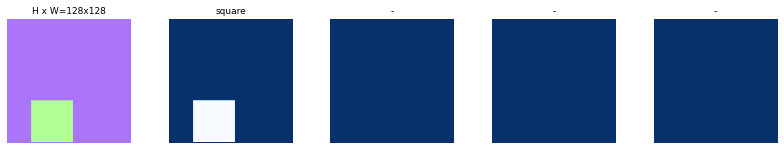

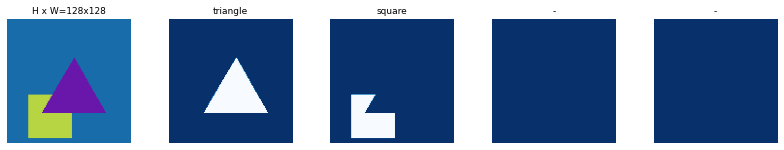

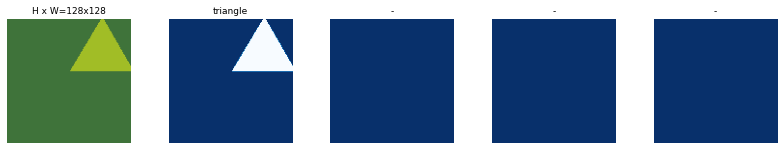

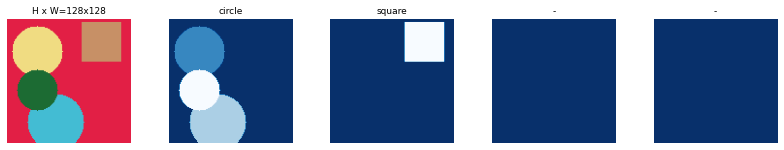

In [7]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [8]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [9]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [10]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\franz\mask_rcnn_models\tf1_test_model_env\Mask_RCNN\logs\shapes20221026T2233\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_c

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\tensorflow\python\ops\gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1


C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

  1/100 [..............................] - ETA: 7:00 - loss: 6.0785 - rpn_class_loss: 0.1142 - rpn_bbox_loss: 2.5717 - mrcnn_class_loss: 1.2883 - mrcnn_bbox_loss: 1.2756 - mrcnn_mask_loss: 0.8288

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

  2/100 [..............................] - ETA: 4:05 - loss: 5.9517 - rpn_class_loss: 0.1055 - rpn_bbox_loss: 2.3478 - mrcnn_class_loss: 1.2809 - mrcnn_bbox_loss: 1.2919 - mrcnn_mask_loss: 0.9256

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

  3/100 [..............................] - ETA: 3:06 - loss: 5.7809 - rpn_class_loss: 0.1000 - rpn_bbox_loss: 2.3560 - mrcnn_class_loss: 1.1796 - mrcnn_bbox_loss: 1.2154 - mrcnn_mask_loss: 0.9299

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

  4/100 [>.............................] - ETA: 2:35 - loss: 5.4478 - rpn_class_loss: 0.0938 - rpn_bbox_loss: 2.1554 - mrcnn_class_loss: 1.1119 - mrcnn_bbox_loss: 1.1524 - mrcnn_mask_loss: 0.9344

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

  5/100 [>.............................] - ETA: 2:19 - loss: 5.1931 - rpn_class_loss: 0.0923 - rpn_bbox_loss: 2.0069 - mrcnn_class_loss: 1.0582 - mrcnn_bbox_loss: 1.0964 - mrcnn_mask_loss: 0.9393

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

  6/100 [>.............................] - ETA: 2:08 - loss: 4.9495 - rpn_class_loss: 0.0882 - rpn_bbox_loss: 1.8560 - mrcnn_class_loss: 1.0307 - mrcnn_bbox_loss: 1.0489 - mrcnn_mask_loss: 0.9257

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

  7/100 [=>............................] - ETA: 2:00 - loss: 4.7497 - rpn_class_loss: 0.0867 - rpn_bbox_loss: 1.7558 - mrcnn_class_loss: 1.0116 - mrcnn_bbox_loss: 0.9996 - mrcnn_mask_loss: 0.8960

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

  8/100 [=>............................] - ETA: 1:53 - loss: 4.6001 - rpn_class_loss: 0.0865 - rpn_bbox_loss: 1.6939 - mrcnn_class_loss: 0.9664 - mrcnn_bbox_loss: 0.9745 - mrcnn_mask_loss: 0.8787

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

  9/100 [=>............................] - ETA: 1:49 - loss: 4.4002 - rpn_class_loss: 0.0842 - rpn_bbox_loss: 1.5802 - mrcnn_class_loss: 0.9281 - mrcnn_bbox_loss: 0.9477 - mrcnn_mask_loss: 0.8601

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 10/100 [==>...........................] - ETA: 1:45 - loss: 4.2500 - rpn_class_loss: 0.0807 - rpn_bbox_loss: 1.5162 - mrcnn_class_loss: 0.8918 - mrcnn_bbox_loss: 0.9244 - mrcnn_mask_loss: 0.8368

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 11/100 [==>...........................] - ETA: 1:42 - loss: 4.1737 - rpn_class_loss: 0.0790 - rpn_bbox_loss: 1.4912 - mrcnn_class_loss: 0.8510 - mrcnn_bbox_loss: 0.9191 - mrcnn_mask_loss: 0.8334

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 12/100 [==>...........................] - ETA: 1:39 - loss: 4.0676 - rpn_class_loss: 0.0782 - rpn_bbox_loss: 1.4390 - mrcnn_class_loss: 0.8227 - mrcnn_bbox_loss: 0.8954 - mrcnn_mask_loss: 0.8323

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 13/100 [==>...........................] - ETA: 1:37 - loss: 3.9711 - rpn_class_loss: 0.0774 - rpn_bbox_loss: 1.3907 - mrcnn_class_loss: 0.7991 - mrcnn_bbox_loss: 0.8817 - mrcnn_mask_loss: 0.8221

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 14/100 [===>..........................] - ETA: 1:34 - loss: 3.8582 - rpn_class_loss: 0.0754 - rpn_bbox_loss: 1.3369 - mrcnn_class_loss: 0.7727 - mrcnn_bbox_loss: 0.8629 - mrcnn_mask_loss: 0.8103

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 15/100 [===>..........................] - ETA: 1:32 - loss: 3.7635 - rpn_class_loss: 0.0750 - rpn_bbox_loss: 1.2930 - mrcnn_class_loss: 0.7502 - mrcnn_bbox_loss: 0.8454 - mrcnn_mask_loss: 0.7999

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 16/100 [===>..........................] - ETA: 1:30 - loss: 3.6764 - rpn_class_loss: 0.0734 - rpn_bbox_loss: 1.2633 - mrcnn_class_loss: 0.7245 - mrcnn_bbox_loss: 0.8269 - mrcnn_mask_loss: 0.7883

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 17/100 [====>.........................] - ETA: 1:27 - loss: 3.5943 - rpn_class_loss: 0.0715 - rpn_bbox_loss: 1.2305 - mrcnn_class_loss: 0.7060 - mrcnn_bbox_loss: 0.8102 - mrcnn_mask_loss: 0.7761

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 18/100 [====>.........................] - ETA: 1:24 - loss: 3.5210 - rpn_class_loss: 0.0708 - rpn_bbox_loss: 1.2138 - mrcnn_class_loss: 0.6865 - mrcnn_bbox_loss: 0.7918 - mrcnn_mask_loss: 0.7581

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 19/100 [====>.........................] - ETA: 1:21 - loss: 3.4530 - rpn_class_loss: 0.0693 - rpn_bbox_loss: 1.1804 - mrcnn_class_loss: 0.6740 - mrcnn_bbox_loss: 0.7816 - mrcnn_mask_loss: 0.7476

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 20/100 [=====>........................] - ETA: 1:19 - loss: 3.3798 - rpn_class_loss: 0.0689 - rpn_bbox_loss: 1.1516 - mrcnn_class_loss: 0.6585 - mrcnn_bbox_loss: 0.7658 - mrcnn_mask_loss: 0.7351

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 21/100 [=====>........................] - ETA: 1:16 - loss: 3.3287 - rpn_class_loss: 0.0684 - rpn_bbox_loss: 1.1339 - mrcnn_class_loss: 0.6442 - mrcnn_bbox_loss: 0.7544 - mrcnn_mask_loss: 0.7278

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 22/100 [=====>........................] - ETA: 1:14 - loss: 3.2794 - rpn_class_loss: 0.0682 - rpn_bbox_loss: 1.1160 - mrcnn_class_loss: 0.6327 - mrcnn_bbox_loss: 0.7423 - mrcnn_mask_loss: 0.7203

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 23/100 [=====>........................] - ETA: 1:11 - loss: 3.2237 - rpn_class_loss: 0.0668 - rpn_bbox_loss: 1.0956 - mrcnn_class_loss: 0.6228 - mrcnn_bbox_loss: 0.7284 - mrcnn_mask_loss: 0.7101

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 24/100 [======>.......................] - ETA: 1:09 - loss: 3.1710 - rpn_class_loss: 0.0656 - rpn_bbox_loss: 1.0743 - mrcnn_class_loss: 0.6124 - mrcnn_bbox_loss: 0.7160 - mrcnn_mask_loss: 0.7028

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 25/100 [======>.......................] - ETA: 1:07 - loss: 3.1109 - rpn_class_loss: 0.0639 - rpn_bbox_loss: 1.0543 - mrcnn_class_loss: 0.5970 - mrcnn_bbox_loss: 0.7003 - mrcnn_mask_loss: 0.6954

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 26/100 [======>.......................] - ETA: 1:04 - loss: 3.0565 - rpn_class_loss: 0.0626 - rpn_bbox_loss: 1.0311 - mrcnn_class_loss: 0.5863 - mrcnn_bbox_loss: 0.6894 - mrcnn_mask_loss: 0.6871

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 27/100 [=======>......................] - ETA: 1:02 - loss: 3.0182 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 1.0220 - mrcnn_class_loss: 0.5782 - mrcnn_bbox_loss: 0.6763 - mrcnn_mask_loss: 0.6798

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 28/100 [=======>......................] - ETA: 1:01 - loss: 2.9825 - rpn_class_loss: 0.0605 - rpn_bbox_loss: 1.0057 - mrcnn_class_loss: 0.5753 - mrcnn_bbox_loss: 0.6661 - mrcnn_mask_loss: 0.6747

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 29/100 [=======>......................] - ETA: 59s - loss: 2.9377 - rpn_class_loss: 0.0592 - rpn_bbox_loss: 0.9902 - mrcnn_class_loss: 0.5656 - mrcnn_bbox_loss: 0.6549 - mrcnn_mask_loss: 0.6678 

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 30/100 [========>.....................] - ETA: 57s - loss: 2.8955 - rpn_class_loss: 0.0579 - rpn_bbox_loss: 0.9746 - mrcnn_class_loss: 0.5572 - mrcnn_bbox_loss: 0.6445 - mrcnn_mask_loss: 0.6613

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 31/100 [========>.....................] - ETA: 55s - loss: 2.8514 - rpn_class_loss: 0.0565 - rpn_bbox_loss: 0.9578 - mrcnn_class_loss: 0.5486 - mrcnn_bbox_loss: 0.6341 - mrcnn_mask_loss: 0.6544

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 32/100 [========>.....................] - ETA: 53s - loss: 2.8094 - rpn_class_loss: 0.0553 - rpn_bbox_loss: 0.9437 - mrcnn_class_loss: 0.5388 - mrcnn_bbox_loss: 0.6251 - mrcnn_mask_loss: 0.6465

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 33/100 [========>.....................] - ETA: 52s - loss: 2.7773 - rpn_class_loss: 0.0543 - rpn_bbox_loss: 0.9343 - mrcnn_class_loss: 0.5310 - mrcnn_bbox_loss: 0.6168 - mrcnn_mask_loss: 0.6408

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 34/100 [=========>....................] - ETA: 50s - loss: 2.7458 - rpn_class_loss: 0.0532 - rpn_bbox_loss: 0.9227 - mrcnn_class_loss: 0.5251 - mrcnn_bbox_loss: 0.6091 - mrcnn_mask_loss: 0.6356

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 35/100 [=========>....................] - ETA: 49s - loss: 2.7165 - rpn_class_loss: 0.0521 - rpn_bbox_loss: 0.9139 - mrcnn_class_loss: 0.5204 - mrcnn_bbox_loss: 0.6006 - mrcnn_mask_loss: 0.6294

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 36/100 [=========>....................] - ETA: 48s - loss: 2.6840 - rpn_class_loss: 0.0512 - rpn_bbox_loss: 0.9052 - mrcnn_class_loss: 0.5130 - mrcnn_bbox_loss: 0.5914 - mrcnn_mask_loss: 0.6233

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 37/100 [==========>...................] - ETA: 46s - loss: 2.6605 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 0.8942 - mrcnn_class_loss: 0.5099 - mrcnn_bbox_loss: 0.5862 - mrcnn_mask_loss: 0.6200

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 38/100 [==========>...................] - ETA: 45s - loss: 2.6300 - rpn_class_loss: 0.0495 - rpn_bbox_loss: 0.8851 - mrcnn_class_loss: 0.5025 - mrcnn_bbox_loss: 0.5794 - mrcnn_mask_loss: 0.6134

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 39/100 [==========>...................] - ETA: 44s - loss: 2.5956 - rpn_class_loss: 0.0487 - rpn_bbox_loss: 0.8734 - mrcnn_class_loss: 0.4958 - mrcnn_bbox_loss: 0.5707 - mrcnn_mask_loss: 0.6070

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 40/100 [===========>..................] - ETA: 43s - loss: 2.5688 - rpn_class_loss: 0.0481 - rpn_bbox_loss: 0.8646 - mrcnn_class_loss: 0.4901 - mrcnn_bbox_loss: 0.5637 - mrcnn_mask_loss: 0.6022

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 41/100 [===========>..................] - ETA: 42s - loss: 2.5359 - rpn_class_loss: 0.0473 - rpn_bbox_loss: 0.8515 - mrcnn_class_loss: 0.4838 - mrcnn_bbox_loss: 0.5568 - mrcnn_mask_loss: 0.5965

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 42/100 [===========>..................] - ETA: 41s - loss: 2.5102 - rpn_class_loss: 0.0466 - rpn_bbox_loss: 0.8427 - mrcnn_class_loss: 0.4792 - mrcnn_bbox_loss: 0.5503 - mrcnn_mask_loss: 0.5914

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 43/100 [===========>..................] - ETA: 40s - loss: 2.4815 - rpn_class_loss: 0.0460 - rpn_bbox_loss: 0.8331 - mrcnn_class_loss: 0.4730 - mrcnn_bbox_loss: 0.5435 - mrcnn_mask_loss: 0.5858

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 44/100 [============>.................] - ETA: 39s - loss: 2.4573 - rpn_class_loss: 0.0454 - rpn_bbox_loss: 0.8239 - mrcnn_class_loss: 0.4688 - mrcnn_bbox_loss: 0.5379 - mrcnn_mask_loss: 0.5813

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 45/100 [============>.................] - ETA: 38s - loss: 2.4377 - rpn_class_loss: 0.0448 - rpn_bbox_loss: 0.8188 - mrcnn_class_loss: 0.4648 - mrcnn_bbox_loss: 0.5323 - mrcnn_mask_loss: 0.5772

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 46/100 [============>.................] - ETA: 37s - loss: 2.4144 - rpn_class_loss: 0.0442 - rpn_bbox_loss: 0.8099 - mrcnn_class_loss: 0.4600 - mrcnn_bbox_loss: 0.5278 - mrcnn_mask_loss: 0.5724

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 47/100 [=============>................] - ETA: 36s - loss: 2.3892 - rpn_class_loss: 0.0437 - rpn_bbox_loss: 0.8005 - mrcnn_class_loss: 0.4555 - mrcnn_bbox_loss: 0.5216 - mrcnn_mask_loss: 0.5679

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 48/100 [=============>................] - ETA: 35s - loss: 2.4014 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 0.8277 - mrcnn_class_loss: 0.4514 - mrcnn_bbox_loss: 0.5162 - mrcnn_mask_loss: 0.5624

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 49/100 [=============>................] - ETA: 34s - loss: 2.3881 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 0.8208 - mrcnn_class_loss: 0.4501 - mrcnn_bbox_loss: 0.5127 - mrcnn_mask_loss: 0.5614

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 50/100 [==============>...............] - ETA: 33s - loss: 2.3667 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 0.8136 - mrcnn_class_loss: 0.4454 - mrcnn_bbox_loss: 0.5079 - mrcnn_mask_loss: 0.5571

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 51/100 [==============>...............] - ETA: 32s - loss: 2.3507 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 0.8064 - mrcnn_class_loss: 0.4446 - mrcnn_bbox_loss: 0.5045 - mrcnn_mask_loss: 0.5532

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 52/100 [==============>...............] - ETA: 32s - loss: 2.3297 - rpn_class_loss: 0.0415 - rpn_bbox_loss: 0.7982 - mrcnn_class_loss: 0.4410 - mrcnn_bbox_loss: 0.5000 - mrcnn_mask_loss: 0.5490

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 53/100 [==============>...............] - ETA: 31s - loss: 2.3065 - rpn_class_loss: 0.0410 - rpn_bbox_loss: 0.7910 - mrcnn_class_loss: 0.4358 - mrcnn_bbox_loss: 0.4947 - mrcnn_mask_loss: 0.5439

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 54/100 [===============>..............] - ETA: 30s - loss: 2.2905 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 0.7857 - mrcnn_class_loss: 0.4322 - mrcnn_bbox_loss: 0.4910 - mrcnn_mask_loss: 0.5410

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 55/100 [===============>..............] - ETA: 29s - loss: 2.2758 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 0.7790 - mrcnn_class_loss: 0.4310 - mrcnn_bbox_loss: 0.4871 - mrcnn_mask_loss: 0.5386

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 56/100 [===============>..............] - ETA: 29s - loss: 2.2600 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 0.7740 - mrcnn_class_loss: 0.4290 - mrcnn_bbox_loss: 0.4822 - mrcnn_mask_loss: 0.5350

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 57/100 [================>.............] - ETA: 28s - loss: 2.2455 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 0.7687 - mrcnn_class_loss: 0.4259 - mrcnn_bbox_loss: 0.4783 - mrcnn_mask_loss: 0.5333

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 58/100 [================>.............] - ETA: 27s - loss: 2.2333 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 0.7642 - mrcnn_class_loss: 0.4255 - mrcnn_bbox_loss: 0.4752 - mrcnn_mask_loss: 0.5296

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 59/100 [================>.............] - ETA: 27s - loss: 2.2195 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 0.7600 - mrcnn_class_loss: 0.4222 - mrcnn_bbox_loss: 0.4728 - mrcnn_mask_loss: 0.5260

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 60/100 [=================>............] - ETA: 26s - loss: 2.2024 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.7543 - mrcnn_class_loss: 0.4179 - mrcnn_bbox_loss: 0.4694 - mrcnn_mask_loss: 0.5226

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 61/100 [=================>............] - ETA: 25s - loss: 2.1854 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.7483 - mrcnn_class_loss: 0.4137 - mrcnn_bbox_loss: 0.4655 - mrcnn_mask_loss: 0.5202

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 62/100 [=================>............] - ETA: 24s - loss: 2.1685 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.7427 - mrcnn_class_loss: 0.4103 - mrcnn_bbox_loss: 0.4625 - mrcnn_mask_loss: 0.5156

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 63/100 [=================>............] - ETA: 24s - loss: 2.1538 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.7368 - mrcnn_class_loss: 0.4079 - mrcnn_bbox_loss: 0.4593 - mrcnn_mask_loss: 0.5127

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 64/100 [==================>...........] - ETA: 23s - loss: 2.1386 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.7345 - mrcnn_class_loss: 0.4041 - mrcnn_bbox_loss: 0.4549 - mrcnn_mask_loss: 0.5084

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 65/100 [==================>...........] - ETA: 22s - loss: 2.1344 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.7399 - mrcnn_class_loss: 0.4010 - mrcnn_bbox_loss: 0.4518 - mrcnn_mask_loss: 0.5049

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 66/100 [==================>...........] - ETA: 22s - loss: 2.1185 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.7342 - mrcnn_class_loss: 0.3985 - mrcnn_bbox_loss: 0.4486 - mrcnn_mask_loss: 0.5008

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 67/100 [===================>..........] - ETA: 21s - loss: 2.1034 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.7303 - mrcnn_class_loss: 0.3951 - mrcnn_bbox_loss: 0.4443 - mrcnn_mask_loss: 0.4977

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 68/100 [===================>..........] - ETA: 20s - loss: 2.0906 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.7257 - mrcnn_class_loss: 0.3924 - mrcnn_bbox_loss: 0.4408 - mrcnn_mask_loss: 0.4959

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 69/100 [===================>..........] - ETA: 20s - loss: 2.0765 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.7220 - mrcnn_class_loss: 0.3888 - mrcnn_bbox_loss: 0.4370 - mrcnn_mask_loss: 0.4932

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 70/100 [====================>.........] - ETA: 19s - loss: 2.0644 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.7191 - mrcnn_class_loss: 0.3859 - mrcnn_bbox_loss: 0.4346 - mrcnn_mask_loss: 0.4896

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 71/100 [====================>.........] - ETA: 19s - loss: 2.0550 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 0.7161 - mrcnn_class_loss: 0.3834 - mrcnn_bbox_loss: 0.4323 - mrcnn_mask_loss: 0.4881

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 72/100 [====================>.........] - ETA: 18s - loss: 2.0415 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.7114 - mrcnn_class_loss: 0.3807 - mrcnn_bbox_loss: 0.4296 - mrcnn_mask_loss: 0.4852

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 73/100 [====================>.........] - ETA: 17s - loss: 2.0269 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.7057 - mrcnn_class_loss: 0.3779 - mrcnn_bbox_loss: 0.4271 - mrcnn_mask_loss: 0.4818

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 74/100 [=====================>........] - ETA: 17s - loss: 2.0140 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.7013 - mrcnn_class_loss: 0.3751 - mrcnn_bbox_loss: 0.4245 - mrcnn_mask_loss: 0.4790

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 75/100 [=====================>........] - ETA: 16s - loss: 2.0016 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.6968 - mrcnn_class_loss: 0.3732 - mrcnn_bbox_loss: 0.4215 - mrcnn_mask_loss: 0.4762

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 76/100 [=====================>........] - ETA: 15s - loss: 1.9947 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.6957 - mrcnn_class_loss: 0.3714 - mrcnn_bbox_loss: 0.4197 - mrcnn_mask_loss: 0.4741

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 77/100 [======================>.......] - ETA: 15s - loss: 1.9866 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.6928 - mrcnn_class_loss: 0.3705 - mrcnn_bbox_loss: 0.4174 - mrcnn_mask_loss: 0.4723

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 78/100 [======================>.......] - ETA: 14s - loss: 1.9772 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.6894 - mrcnn_class_loss: 0.3683 - mrcnn_bbox_loss: 0.4150 - mrcnn_mask_loss: 0.4709

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 79/100 [======================>.......] - ETA: 13s - loss: 1.9672 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.6872 - mrcnn_class_loss: 0.3657 - mrcnn_bbox_loss: 0.4126 - mrcnn_mask_loss: 0.4682

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 80/100 [=======================>......] - ETA: 13s - loss: 1.9554 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.6840 - mrcnn_class_loss: 0.3633 - mrcnn_bbox_loss: 0.4098 - mrcnn_mask_loss: 0.4651

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 81/100 [=======================>......] - ETA: 12s - loss: 1.9429 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.6803 - mrcnn_class_loss: 0.3604 - mrcnn_bbox_loss: 0.4071 - mrcnn_mask_loss: 0.4622

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 82/100 [=======================>......] - ETA: 11s - loss: 1.9340 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.6779 - mrcnn_class_loss: 0.3583 - mrcnn_bbox_loss: 0.4048 - mrcnn_mask_loss: 0.4601

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 83/100 [=======================>......] - ETA: 11s - loss: 1.9197 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.6739 - mrcnn_class_loss: 0.3553 - mrcnn_bbox_loss: 0.4014 - mrcnn_mask_loss: 0.4564

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 84/100 [========================>.....] - ETA: 10s - loss: 1.9125 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.6709 - mrcnn_class_loss: 0.3538 - mrcnn_bbox_loss: 0.3994 - mrcnn_mask_loss: 0.4559

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 85/100 [========================>.....] - ETA: 9s - loss: 1.9001 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.6676 - mrcnn_class_loss: 0.3509 - mrcnn_bbox_loss: 0.3959 - mrcnn_mask_loss: 0.4536 

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 86/100 [========================>.....] - ETA: 9s - loss: 1.8903 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.6646 - mrcnn_class_loss: 0.3494 - mrcnn_bbox_loss: 0.3933 - mrcnn_mask_loss: 0.4511

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 87/100 [=========================>....] - ETA: 8s - loss: 1.8813 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.6618 - mrcnn_class_loss: 0.3481 - mrcnn_bbox_loss: 0.3912 - mrcnn_mask_loss: 0.4484

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 88/100 [=========================>....] - ETA: 7s - loss: 1.8719 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 0.6580 - mrcnn_class_loss: 0.3469 - mrcnn_bbox_loss: 0.3894 - mrcnn_mask_loss: 0.4461

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 89/100 [=========================>....] - ETA: 7s - loss: 1.8619 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 0.6558 - mrcnn_class_loss: 0.3447 - mrcnn_bbox_loss: 0.3869 - mrcnn_mask_loss: 0.4432

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 90/100 [==========================>...] - ETA: 6s - loss: 1.8516 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.6524 - mrcnn_class_loss: 0.3427 - mrcnn_bbox_loss: 0.3844 - mrcnn_mask_loss: 0.4409

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 91/100 [==========================>...] - ETA: 5s - loss: 1.8420 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 0.6501 - mrcnn_class_loss: 0.3406 - mrcnn_bbox_loss: 0.3820 - mrcnn_mask_loss: 0.4383

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 92/100 [==========================>...] - ETA: 5s - loss: 1.8366 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.6486 - mrcnn_class_loss: 0.3405 - mrcnn_bbox_loss: 0.3805 - mrcnn_mask_loss: 0.4362

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 93/100 [==========================>...] - ETA: 4s - loss: 1.8289 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.6457 - mrcnn_class_loss: 0.3392 - mrcnn_bbox_loss: 0.3788 - mrcnn_mask_loss: 0.4346

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 94/100 [===========================>..] - ETA: 3s - loss: 1.8196 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.6424 - mrcnn_class_loss: 0.3379 - mrcnn_bbox_loss: 0.3768 - mrcnn_mask_loss: 0.4321

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 95/100 [===========================>..] - ETA: 3s - loss: 1.8136 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.6400 - mrcnn_class_loss: 0.3377 - mrcnn_bbox_loss: 0.3752 - mrcnn_mask_loss: 0.4303

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 96/100 [===========================>..] - ETA: 2s - loss: 1.8082 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.6385 - mrcnn_class_loss: 0.3371 - mrcnn_bbox_loss: 0.3734 - mrcnn_mask_loss: 0.4290

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 97/100 [============================>.] - ETA: 1s - loss: 1.8008 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.6368 - mrcnn_class_loss: 0.3356 - mrcnn_bbox_loss: 0.3713 - mrcnn_mask_loss: 0.4270

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 98/100 [============================>.] - ETA: 1s - loss: 1.7936 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 0.6353 - mrcnn_class_loss: 0.3343 - mrcnn_bbox_loss: 0.3691 - mrcnn_mask_loss: 0.4249

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 99/100 [============================>.] - ETA: 0s - loss: 1.7859 - rpn_class_loss: 0.0298 - rpn_bbox_loss: 0.6339 - mrcnn_class_loss: 0.3327 - mrcnn_bbox_loss: 0.3669 - mrcnn_mask_loss: 0.4226

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

100/100 [==============================] - 92s 915ms/step - loss: 1.7780 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.6323 - mrcnn_class_loss: 0.3310 - mrcnn_bbox_loss: 0.3651 - mrcnn_mask_loss: 0.4200 - val_loss: 1.0590 - val_rpn_class_loss: 0.0150 - val_rpn_bbox_loss: 0.4195 - val_mrcnn_class_loss: 0.1854 - val_mrcnn_bbox_loss: 0.1936 - val_mrcnn_mask_loss: 0.2455


In [11]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: C:\Users\franz\mask_rcnn_models\tf1_test_model_env\Mask_RCNN\logs\shapes20221026T2233\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
re

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\tensorflow\python\ops\gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 2/2


C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

  1/100 [..............................] - ETA: 8:04 - loss: 1.0354 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.3337 - mrcnn_class_loss: 0.2646 - mrcnn_bbox_loss: 0.1911 - mrcnn_mask_loss: 0.2278

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

  2/100 [..............................] - ETA: 4:26 - loss: 1.0422 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.4016 - mrcnn_class_loss: 0.2429 - mrcnn_bbox_loss: 0.1868 - mrcnn_mask_loss: 0.1957

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

  3/100 [..............................] - ETA: 3:16 - loss: 1.2920 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.6836 - mrcnn_class_loss: 0.2155 - mrcnn_bbox_loss: 0.1776 - mrcnn_mask_loss: 0.1957

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

  4/100 [>.............................] - ETA: 2:39 - loss: 1.1955 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.6422 - mrcnn_class_loss: 0.1914 - mrcnn_bbox_loss: 0.1656 - mrcnn_mask_loss: 0.1762

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

  5/100 [>.............................] - ETA: 2:16 - loss: 1.1873 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.6138 - mrcnn_class_loss: 0.2061 - mrcnn_bbox_loss: 0.1661 - mrcnn_mask_loss: 0.1826

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

  6/100 [>.............................] - ETA: 2:01 - loss: 1.1749 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.5801 - mrcnn_class_loss: 0.2102 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.1948

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

  7/100 [=>............................] - ETA: 1:51 - loss: 1.1350 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.5480 - mrcnn_class_loss: 0.2045 - mrcnn_bbox_loss: 0.1698 - mrcnn_mask_loss: 0.1953

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

  8/100 [=>............................] - ETA: 1:42 - loss: 1.1252 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.5398 - mrcnn_class_loss: 0.2062 - mrcnn_bbox_loss: 0.1671 - mrcnn_mask_loss: 0.1950

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

  9/100 [=>............................] - ETA: 1:35 - loss: 1.1351 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.5376 - mrcnn_class_loss: 0.2087 - mrcnn_bbox_loss: 0.1738 - mrcnn_mask_loss: 0.1977

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 10/100 [==>...........................] - ETA: 1:30 - loss: 1.1464 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.5312 - mrcnn_class_loss: 0.2088 - mrcnn_bbox_loss: 0.1752 - mrcnn_mask_loss: 0.2138

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 11/100 [==>...........................] - ETA: 1:25 - loss: 1.1225 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.5155 - mrcnn_class_loss: 0.2049 - mrcnn_bbox_loss: 0.1715 - mrcnn_mask_loss: 0.2140

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 12/100 [==>...........................] - ETA: 1:21 - loss: 1.1099 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.5073 - mrcnn_class_loss: 0.2033 - mrcnn_bbox_loss: 0.1678 - mrcnn_mask_loss: 0.2151

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 13/100 [==>...........................] - ETA: 1:18 - loss: 1.0837 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4952 - mrcnn_class_loss: 0.1968 - mrcnn_bbox_loss: 0.1641 - mrcnn_mask_loss: 0.2116

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 14/100 [===>..........................] - ETA: 1:15 - loss: 1.0820 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4935 - mrcnn_class_loss: 0.1985 - mrcnn_bbox_loss: 0.1627 - mrcnn_mask_loss: 0.2110

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 15/100 [===>..........................] - ETA: 1:12 - loss: 1.0662 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4863 - mrcnn_class_loss: 0.1945 - mrcnn_bbox_loss: 0.1596 - mrcnn_mask_loss: 0.2097

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 16/100 [===>..........................] - ETA: 1:10 - loss: 1.0658 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.4822 - mrcnn_class_loss: 0.1976 - mrcnn_bbox_loss: 0.1586 - mrcnn_mask_loss: 0.2115

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 17/100 [====>.........................] - ETA: 1:08 - loss: 1.0773 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.4872 - mrcnn_class_loss: 0.2001 - mrcnn_bbox_loss: 0.1596 - mrcnn_mask_loss: 0.2146

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 18/100 [====>.........................] - ETA: 1:06 - loss: 1.0760 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.4831 - mrcnn_class_loss: 0.2011 - mrcnn_bbox_loss: 0.1591 - mrcnn_mask_loss: 0.2170

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 19/100 [====>.........................] - ETA: 1:04 - loss: 1.0777 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.4823 - mrcnn_class_loss: 0.2044 - mrcnn_bbox_loss: 0.1590 - mrcnn_mask_loss: 0.2162

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 20/100 [=====>........................] - ETA: 1:02 - loss: 1.0739 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4858 - mrcnn_class_loss: 0.2013 - mrcnn_bbox_loss: 0.1561 - mrcnn_mask_loss: 0.2144

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 21/100 [=====>........................] - ETA: 1:01 - loss: 1.0793 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.4836 - mrcnn_class_loss: 0.2022 - mrcnn_bbox_loss: 0.1581 - mrcnn_mask_loss: 0.2190

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 22/100 [=====>........................] - ETA: 59s - loss: 1.0675 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4807 - mrcnn_class_loss: 0.1994 - mrcnn_bbox_loss: 0.1558 - mrcnn_mask_loss: 0.2153 

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 23/100 [=====>........................] - ETA: 58s - loss: 1.0690 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.4782 - mrcnn_class_loss: 0.1999 - mrcnn_bbox_loss: 0.1562 - mrcnn_mask_loss: 0.2180

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 24/100 [======>.......................] - ETA: 56s - loss: 1.0594 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4724 - mrcnn_class_loss: 0.1972 - mrcnn_bbox_loss: 0.1553 - mrcnn_mask_loss: 0.2179

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 25/100 [======>.......................] - ETA: 55s - loss: 1.0575 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.4715 - mrcnn_class_loss: 0.1969 - mrcnn_bbox_loss: 0.1539 - mrcnn_mask_loss: 0.2187

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 26/100 [======>.......................] - ETA: 54s - loss: 1.0513 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.4716 - mrcnn_class_loss: 0.1954 - mrcnn_bbox_loss: 0.1523 - mrcnn_mask_loss: 0.2156

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 27/100 [=======>......................] - ETA: 53s - loss: 1.0450 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.4661 - mrcnn_class_loss: 0.1952 - mrcnn_bbox_loss: 0.1515 - mrcnn_mask_loss: 0.2157

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 28/100 [=======>......................] - ETA: 52s - loss: 1.0474 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.4626 - mrcnn_class_loss: 0.1991 - mrcnn_bbox_loss: 0.1510 - mrcnn_mask_loss: 0.2180

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 29/100 [=======>......................] - ETA: 50s - loss: 1.0411 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.4607 - mrcnn_class_loss: 0.1976 - mrcnn_bbox_loss: 0.1502 - mrcnn_mask_loss: 0.2158

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 30/100 [========>.....................] - ETA: 49s - loss: 1.0355 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.4587 - mrcnn_class_loss: 0.1964 - mrcnn_bbox_loss: 0.1489 - mrcnn_mask_loss: 0.2150

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 31/100 [========>.....................] - ETA: 48s - loss: 1.0319 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4614 - mrcnn_class_loss: 0.1948 - mrcnn_bbox_loss: 0.1469 - mrcnn_mask_loss: 0.2126

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 32/100 [========>.....................] - ETA: 47s - loss: 1.0350 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4605 - mrcnn_class_loss: 0.1965 - mrcnn_bbox_loss: 0.1481 - mrcnn_mask_loss: 0.2135

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 33/100 [========>.....................] - ETA: 46s - loss: 1.0342 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4590 - mrcnn_class_loss: 0.1964 - mrcnn_bbox_loss: 0.1481 - mrcnn_mask_loss: 0.2145

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 34/100 [=========>....................] - ETA: 45s - loss: 1.0348 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4584 - mrcnn_class_loss: 0.1959 - mrcnn_bbox_loss: 0.1487 - mrcnn_mask_loss: 0.2157

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 35/100 [=========>....................] - ETA: 45s - loss: 1.0388 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4580 - mrcnn_class_loss: 0.1975 - mrcnn_bbox_loss: 0.1481 - mrcnn_mask_loss: 0.2192

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 36/100 [=========>....................] - ETA: 44s - loss: 1.0356 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4563 - mrcnn_class_loss: 0.1966 - mrcnn_bbox_loss: 0.1474 - mrcnn_mask_loss: 0.2193

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 37/100 [==========>...................] - ETA: 43s - loss: 1.0260 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.4524 - mrcnn_class_loss: 0.1950 - mrcnn_bbox_loss: 0.1460 - mrcnn_mask_loss: 0.2166

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 38/100 [==========>...................] - ETA: 42s - loss: 1.0269 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.4518 - mrcnn_class_loss: 0.1943 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.2178

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 39/100 [==========>...................] - ETA: 41s - loss: 1.0263 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.4507 - mrcnn_class_loss: 0.1962 - mrcnn_bbox_loss: 0.1461 - mrcnn_mask_loss: 0.2177

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 40/100 [===========>..................] - ETA: 40s - loss: 1.0247 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.4480 - mrcnn_class_loss: 0.1972 - mrcnn_bbox_loss: 0.1465 - mrcnn_mask_loss: 0.2175

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 41/100 [===========>..................] - ETA: 39s - loss: 1.0279 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.4482 - mrcnn_class_loss: 0.1985 - mrcnn_bbox_loss: 0.1470 - mrcnn_mask_loss: 0.2183

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 42/100 [===========>..................] - ETA: 39s - loss: 1.0277 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.4474 - mrcnn_class_loss: 0.1997 - mrcnn_bbox_loss: 0.1473 - mrcnn_mask_loss: 0.2174

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 43/100 [===========>..................] - ETA: 38s - loss: 1.0260 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4463 - mrcnn_class_loss: 0.2004 - mrcnn_bbox_loss: 0.1463 - mrcnn_mask_loss: 0.2171

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 44/100 [============>.................] - ETA: 37s - loss: 1.0307 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.4460 - mrcnn_class_loss: 0.2021 - mrcnn_bbox_loss: 0.1474 - mrcnn_mask_loss: 0.2193

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 45/100 [============>.................] - ETA: 36s - loss: 1.0305 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4463 - mrcnn_class_loss: 0.2025 - mrcnn_bbox_loss: 0.1465 - mrcnn_mask_loss: 0.2190

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 46/100 [============>.................] - ETA: 35s - loss: 1.0308 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4466 - mrcnn_class_loss: 0.2030 - mrcnn_bbox_loss: 0.1462 - mrcnn_mask_loss: 0.2189

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 47/100 [=============>................] - ETA: 35s - loss: 1.0312 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4475 - mrcnn_class_loss: 0.2024 - mrcnn_bbox_loss: 0.1462 - mrcnn_mask_loss: 0.2188

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 48/100 [=============>................] - ETA: 34s - loss: 1.0346 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4473 - mrcnn_class_loss: 0.2043 - mrcnn_bbox_loss: 0.1460 - mrcnn_mask_loss: 0.2208

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 49/100 [=============>................] - ETA: 33s - loss: 1.0359 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4480 - mrcnn_class_loss: 0.2045 - mrcnn_bbox_loss: 0.1458 - mrcnn_mask_loss: 0.2214

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 50/100 [==============>...............] - ETA: 32s - loss: 1.0385 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4465 - mrcnn_class_loss: 0.2058 - mrcnn_bbox_loss: 0.1473 - mrcnn_mask_loss: 0.2228

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 51/100 [==============>...............] - ETA: 32s - loss: 1.0366 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4462 - mrcnn_class_loss: 0.2044 - mrcnn_bbox_loss: 0.1473 - mrcnn_mask_loss: 0.2226

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 52/100 [==============>...............] - ETA: 31s - loss: 1.0417 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4475 - mrcnn_class_loss: 0.2060 - mrcnn_bbox_loss: 0.1479 - mrcnn_mask_loss: 0.2240

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 53/100 [==============>...............] - ETA: 30s - loss: 1.0399 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4459 - mrcnn_class_loss: 0.2054 - mrcnn_bbox_loss: 0.1474 - mrcnn_mask_loss: 0.2248

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 54/100 [===============>..............] - ETA: 30s - loss: 1.0325 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4431 - mrcnn_class_loss: 0.2038 - mrcnn_bbox_loss: 0.1461 - mrcnn_mask_loss: 0.2233

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 55/100 [===============>..............] - ETA: 29s - loss: 1.0323 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4442 - mrcnn_class_loss: 0.2034 - mrcnn_bbox_loss: 0.1454 - mrcnn_mask_loss: 0.2231

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 56/100 [===============>..............] - ETA: 28s - loss: 1.0299 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4437 - mrcnn_class_loss: 0.2031 - mrcnn_bbox_loss: 0.1447 - mrcnn_mask_loss: 0.2221

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 57/100 [================>.............] - ETA: 27s - loss: 1.0290 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4426 - mrcnn_class_loss: 0.2029 - mrcnn_bbox_loss: 0.1449 - mrcnn_mask_loss: 0.2223

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 58/100 [================>.............] - ETA: 27s - loss: 1.0253 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4407 - mrcnn_class_loss: 0.2026 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.2214

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 59/100 [================>.............] - ETA: 26s - loss: 1.0257 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4409 - mrcnn_class_loss: 0.2023 - mrcnn_bbox_loss: 0.1441 - mrcnn_mask_loss: 0.2222

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 60/100 [=================>............] - ETA: 25s - loss: 1.0232 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4383 - mrcnn_class_loss: 0.2023 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.2227

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 61/100 [=================>............] - ETA: 25s - loss: 1.0256 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4373 - mrcnn_class_loss: 0.2034 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.2243

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 62/100 [=================>............] - ETA: 24s - loss: 1.0269 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4374 - mrcnn_class_loss: 0.2039 - mrcnn_bbox_loss: 0.1442 - mrcnn_mask_loss: 0.2252

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 63/100 [=================>............] - ETA: 23s - loss: 1.0264 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4377 - mrcnn_class_loss: 0.2035 - mrcnn_bbox_loss: 0.1439 - mrcnn_mask_loss: 0.2250

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 64/100 [==================>...........] - ETA: 23s - loss: 1.0252 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4378 - mrcnn_class_loss: 0.2030 - mrcnn_bbox_loss: 0.1436 - mrcnn_mask_loss: 0.2247

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 65/100 [==================>...........] - ETA: 22s - loss: 1.0231 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4371 - mrcnn_class_loss: 0.2025 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.2240

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 66/100 [==================>...........] - ETA: 21s - loss: 1.0203 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4373 - mrcnn_class_loss: 0.2017 - mrcnn_bbox_loss: 0.1425 - mrcnn_mask_loss: 0.2228

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 67/100 [===================>..........] - ETA: 21s - loss: 1.0181 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4377 - mrcnn_class_loss: 0.2004 - mrcnn_bbox_loss: 0.1416 - mrcnn_mask_loss: 0.2224

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 68/100 [===================>..........] - ETA: 20s - loss: 1.0216 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4375 - mrcnn_class_loss: 0.2019 - mrcnn_bbox_loss: 0.1423 - mrcnn_mask_loss: 0.2237

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 69/100 [===================>..........] - ETA: 19s - loss: 1.0173 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4364 - mrcnn_class_loss: 0.2008 - mrcnn_bbox_loss: 0.1414 - mrcnn_mask_loss: 0.2226

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 70/100 [====================>.........] - ETA: 19s - loss: 1.0165 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4383 - mrcnn_class_loss: 0.1998 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.2214

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 71/100 [====================>.........] - ETA: 18s - loss: 1.0160 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4396 - mrcnn_class_loss: 0.1996 - mrcnn_bbox_loss: 0.1404 - mrcnn_mask_loss: 0.2203

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 72/100 [====================>.........] - ETA: 17s - loss: 1.0172 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4386 - mrcnn_class_loss: 0.2007 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.2208

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 73/100 [====================>.........] - ETA: 17s - loss: 1.0160 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4390 - mrcnn_class_loss: 0.2001 - mrcnn_bbox_loss: 0.1405 - mrcnn_mask_loss: 0.2202

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 74/100 [=====================>........] - ETA: 16s - loss: 1.0171 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4389 - mrcnn_class_loss: 0.2008 - mrcnn_bbox_loss: 0.1405 - mrcnn_mask_loss: 0.2208

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 75/100 [=====================>........] - ETA: 15s - loss: 1.0153 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4389 - mrcnn_class_loss: 0.2001 - mrcnn_bbox_loss: 0.1398 - mrcnn_mask_loss: 0.2203

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 76/100 [=====================>........] - ETA: 15s - loss: 1.0161 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4386 - mrcnn_class_loss: 0.2005 - mrcnn_bbox_loss: 0.1402 - mrcnn_mask_loss: 0.2206

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 77/100 [======================>.......] - ETA: 14s - loss: 1.0158 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4389 - mrcnn_class_loss: 0.2004 - mrcnn_bbox_loss: 0.1396 - mrcnn_mask_loss: 0.2207

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 78/100 [======================>.......] - ETA: 13s - loss: 1.0127 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4379 - mrcnn_class_loss: 0.1990 - mrcnn_bbox_loss: 0.1389 - mrcnn_mask_loss: 0.2208

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 79/100 [======================>.......] - ETA: 13s - loss: 1.0126 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4380 - mrcnn_class_loss: 0.1981 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2208

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 80/100 [=======================>......] - ETA: 12s - loss: 1.0139 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4382 - mrcnn_class_loss: 0.1984 - mrcnn_bbox_loss: 0.1397 - mrcnn_mask_loss: 0.2214

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 81/100 [=======================>......] - ETA: 12s - loss: 1.0110 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4368 - mrcnn_class_loss: 0.1977 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2211

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 82/100 [=======================>......] - ETA: 11s - loss: 1.0095 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4364 - mrcnn_class_loss: 0.1971 - mrcnn_bbox_loss: 0.1387 - mrcnn_mask_loss: 0.2211

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 83/100 [=======================>......] - ETA: 10s - loss: 1.0098 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4373 - mrcnn_class_loss: 0.1964 - mrcnn_bbox_loss: 0.1386 - mrcnn_mask_loss: 0.2212

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 84/100 [========================>.....] - ETA: 10s - loss: 1.0088 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4374 - mrcnn_class_loss: 0.1962 - mrcnn_bbox_loss: 0.1383 - mrcnn_mask_loss: 0.2207

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 85/100 [========================>.....] - ETA: 9s - loss: 1.0075 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4374 - mrcnn_class_loss: 0.1958 - mrcnn_bbox_loss: 0.1380 - mrcnn_mask_loss: 0.2200 

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 86/100 [========================>.....] - ETA: 8s - loss: 1.0078 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4381 - mrcnn_class_loss: 0.1959 - mrcnn_bbox_loss: 0.1377 - mrcnn_mask_loss: 0.2199

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 87/100 [=========================>....] - ETA: 8s - loss: 1.0077 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4389 - mrcnn_class_loss: 0.1952 - mrcnn_bbox_loss: 0.1375 - mrcnn_mask_loss: 0.2198

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 88/100 [=========================>....] - ETA: 7s - loss: 1.0055 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4377 - mrcnn_class_loss: 0.1949 - mrcnn_bbox_loss: 0.1373 - mrcnn_mask_loss: 0.2192

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 89/100 [=========================>....] - ETA: 6s - loss: 1.0049 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4382 - mrcnn_class_loss: 0.1948 - mrcnn_bbox_loss: 0.1372 - mrcnn_mask_loss: 0.2185

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 90/100 [==========================>...] - ETA: 6s - loss: 1.0015 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4372 - mrcnn_class_loss: 0.1941 - mrcnn_bbox_loss: 0.1364 - mrcnn_mask_loss: 0.2175

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 91/100 [==========================>...] - ETA: 5s - loss: 1.0007 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4374 - mrcnn_class_loss: 0.1937 - mrcnn_bbox_loss: 0.1360 - mrcnn_mask_loss: 0.2172

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 92/100 [==========================>...] - ETA: 5s - loss: 1.0032 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4374 - mrcnn_class_loss: 0.1953 - mrcnn_bbox_loss: 0.1362 - mrcnn_mask_loss: 0.2179

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 93/100 [==========================>...] - ETA: 4s - loss: 1.0015 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4368 - mrcnn_class_loss: 0.1951 - mrcnn_bbox_loss: 0.1359 - mrcnn_mask_loss: 0.2175

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 94/100 [===========================>..] - ETA: 3s - loss: 1.0089 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.4453 - mrcnn_class_loss: 0.1946 - mrcnn_bbox_loss: 0.1357 - mrcnn_mask_loss: 0.2168

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 95/100 [===========================>..] - ETA: 3s - loss: 1.0075 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.4446 - mrcnn_class_loss: 0.1947 - mrcnn_bbox_loss: 0.1353 - mrcnn_mask_loss: 0.2164

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 96/100 [===========================>..] - ETA: 2s - loss: 1.0053 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.4432 - mrcnn_class_loss: 0.1945 - mrcnn_bbox_loss: 0.1348 - mrcnn_mask_loss: 0.2163

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 97/100 [============================>.] - ETA: 1s - loss: 1.0023 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4422 - mrcnn_class_loss: 0.1939 - mrcnn_bbox_loss: 0.1344 - mrcnn_mask_loss: 0.2155

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 98/100 [============================>.] - ETA: 1s - loss: 1.0016 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4415 - mrcnn_class_loss: 0.1937 - mrcnn_bbox_loss: 0.1343 - mrcnn_mask_loss: 0.2158

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 99/100 [============================>.] - ETA: 0s - loss: 1.0003 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4412 - mrcnn_class_loss: 0.1931 - mrcnn_bbox_loss: 0.1343 - mrcnn_mask_loss: 0.2156

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\franz\.conda\envs\MASK_RCNN_env_v0\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

100/100 [==============================] - 66s 655ms/step - loss: 0.9982 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4402 - mrcnn_class_loss: 0.1931 - mrcnn_bbox_loss: 0.1338 - mrcnn_mask_loss: 0.2150 - val_loss: 0.9857 - val_rpn_class_loss: 0.0157 - val_rpn_bbox_loss: 0.4456 - val_mrcnn_class_loss: 0.1726 - val_mrcnn_bbox_loss: 0.1347 - val_mrcnn_mask_loss: 0.2171


In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [12]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  C:\Users\franz\mask_rcnn_models\tf1_test_model_env\Mask_RCNN\logs\shapes20221026T2233\mask_rcnn_shapes_0002.h5
Re-starting from epoch 2


original_image           shape: (128, 128, 3)         min:   28.00000  max:  225.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max:  128.00000  int32
gt_class_id              shape: (2,)                  min:    1.00000  max:    3.00000  int32
gt_bbox                  shape: (2, 4)                min:    6.00000  max:  108.00000  int32
gt_mask                  shape: (128, 128, 2)         min:    0.00000  max:    1.00000  bool


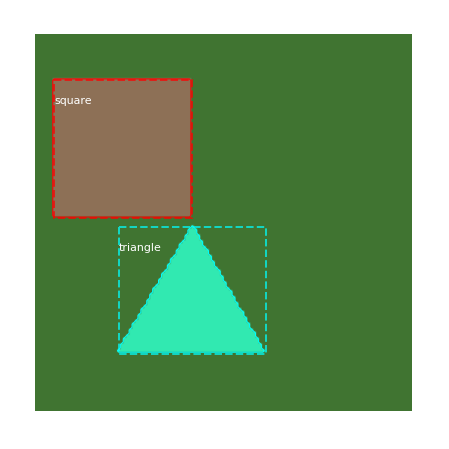

In [28]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:   28.00000  max:  225.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min:  -95.70000  max:  108.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  128.00000  int32
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


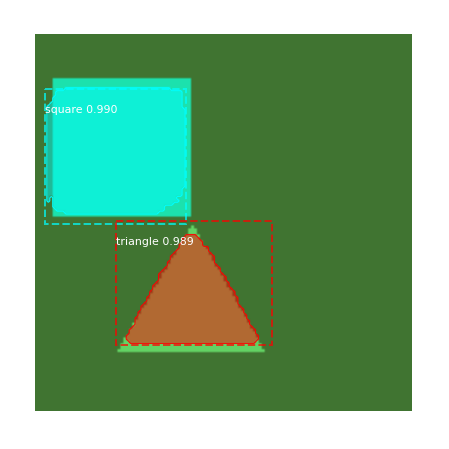

In [30]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [31]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.9166666686534881
